## Emotika: Emotion Detection in Text


In [1]:
import pandas as pd

In [61]:
import matplotlib.pyplot as plt


def plot_training_history(history):
    # Plot training & validation accuracy values
    plt.plot(history.history['accuracy'])
    plt.plot(history.history['val_accuracy'])
    plt.title('Model accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend(['Train', 'Validation'], loc='upper left')
    plt.show()

    # Plot training & validation loss values
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('Model loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend(['Train', 'Validation'], loc='upper left')
    plt.show()

In [7]:
train_data = pd.read_csv('data/raw/train.txt', sep=';',
                         header=None, names=['text', 'emotion'])
test_data = pd.read_csv('data/raw/test.txt', sep=';',
                        header=None, names=['text', 'emotion'])
val_data = pd.read_csv('data/raw/val.txt', sep=';',
                       header=None, names=['text', 'emotion'])

In [8]:
train_data.describe()

,text,emotion
count,16000,16000
unique,15969,6
top,i feel on the verge of tears from weariness i ...,joy
freq,2,5362


<Axes: xlabel='emotion'>

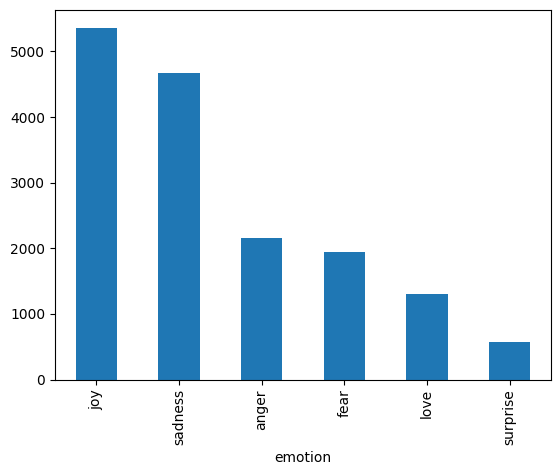

In [9]:
train_data['emotion'].value_counts().plot(kind='bar')

In [10]:
emotions_map = {
    'joy': 0,
    'sadness': 1,
    'anger': 2,
    'fear': 3,
    'love': 4,
    'surprise': 5,
}

In [11]:
train_data["emotion"] = train_data["emotion"].map(emotions_map)
test_data["emotion"] = test_data["emotion"].map(emotions_map)
val_data["emotion"] = val_data["emotion"].map(emotions_map)

In [12]:
train_data.head()

,text,emotion
0,i didnt feel humiliated,1
1,i can go from feeling so hopeless to so damned...,1
2,im grabbing a minute to post i feel greedy wrong,2
3,i am ever feeling nostalgic about the fireplac...,4
4,i am feeling grouchy,2


In [14]:
# stopword removal
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize


def remove_stopwords(text):
    stop_words = set(stopwords.words('english'))
    word_tokens = word_tokenize(text)
    filtered_text = [word for word in word_tokens if word not in stop_words]
    return ' '.join(filtered_text)

In [15]:
# remove from df
train_data['text'] = train_data['text'].apply(remove_stopwords)
test_data['text'] = test_data['text'].apply(remove_stopwords)
val_data['text'] = val_data['text'].apply(remove_stopwords)

In [46]:
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Dense, Conv1D, MaxPooling1D, GlobalMaxPooling1D, Dropout, SpatialDropout1D, Input
from tensorflow.keras.preprocessing.text import Tokenizer

In [18]:
from collections import Counter
texts = train_data['text'].to_list()
# Tokenization without setting num_words
tokenizer = Tokenizer()
tokenizer.fit_on_texts(texts)

# Word frequencies
word_counts = tokenizer.word_counts

# Sort word frequencies in descending order
sorted_word_counts = sorted(
    word_counts.items(), key=lambda x: x[1], reverse=True)

In [19]:
sorted_word_counts[:10]

[('feel', 11183),
 ('feeling', 5112),
 ('like', 2908),
 ('im', 2430),
 ('really', 942),
 ('know', 853),
 ('time', 794),
 ('get', 740),
 ('little', 736),
 ('people', 654)]

In [34]:
# Tokenizer

# our num_words will be 11,183

filter = '!"#$%&()*+,-./:;<=>?@[\\]^_`{|}~\t\n'
tokenizer = Tokenizer(num_words=11183, filters=filter, lower=True)
tokenizer.fit_on_texts(train_data['text'])

In [35]:
X_train_seq = tokenizer.texts_to_sequences(train_data['text'])
X_val_seq = tokenizer.texts_to_sequences(val_data['text'])
X_test_seq = tokenizer.texts_to_sequences(test_data['text'])

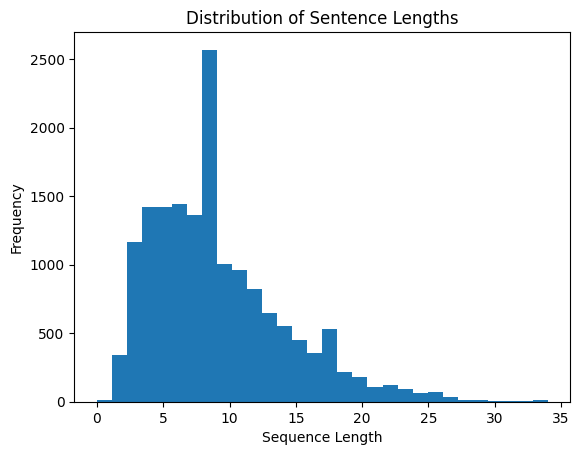

In [36]:
import matplotlib.pyplot as plt
sequence_lengths = [len(seq) for seq in X_train_seq]
plt.hist(sequence_lengths, bins=30)
plt.xlabel('Sequence Length')
plt.ylabel('Frequency')
plt.title('Distribution of Sentence Lengths')
plt.show()

In [37]:
# Pad sequences to ensure uniform length
max_length = 35

X_train_padded = pad_sequences(X_train_seq, maxlen=max_length, padding='post')
X_val_padded = pad_sequences(X_val_seq, maxlen=max_length, padding='post')
X_test_padded = pad_sequences(X_test_seq, maxlen=max_length, padding='post')

In [52]:
model = Sequential([
    Input(shape=(max_length,)),
    Embedding(input_dim=len(tokenizer.word_index)+1,
              output_dim=128, input_length=max_length),
    SpatialDropout1D(0.5),
    LSTM(128, dropout=0.5, recurrent_dropout=0.5,
         name='lstm1', return_sequences=True),
    Conv1D(filters=128, kernel_size=10, strides=3,
           padding="valid", activation='relu', name='conv1d1'),
    Dropout(0.5, name='dropout1'),
    LSTM(128, dropout=0.5, recurrent_dropout=0.5,
         name='lstm2', return_sequences=True),
    # Conv1D(filters=128, kernel_size=10, strides=3, padding="valid", activation='relu', name='conv1d2'),
    Dropout(0.5, name='dropout2'),
    GlobalMaxPooling1D(),
    Dense(len(emotions_map), activation='softmax')
])

# Compile the model
model.compile(loss='sparse_categorical_crossentropy',
              optimizer='adam', metrics=['accuracy'])

model.summary()


Model: "sequential_12"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_14 (Embedding)    (None, 35, 128)           1928064   
                                                                 
 spatial_dropout1d_13 (Spat  (None, 35, 128)           0         
 ialDropout1D)                                                   
                                                                 
 lstm1 (LSTM)                (None, 35, 128)           131584    
                                                                 
 conv1d1 (Conv1D)            (None, 9, 128)            163968    
                                                                 
 dropout1 (Dropout)          (None, 9, 128)            0         
                                                                 
 lstm2 (LSTM)                (None, 9, 128)            131584    
                                                    

In [54]:
# Train the model
history = model.fit(X_train_padded, train_data["emotion"], batch_size=128,
                    epochs=10, validation_data=(X_val_padded, val_data["emotion"]))

Epoch 1/10


125/125 [==============================] - 29s 146ms/step - loss: 1.5423 - accuracy: 0.3356 - val_loss: 1.3565 - val_accuracy: 0.4175
Epoch 2/10
125/125 [==============================] - 17s 132ms/step - loss: 1.1625 - accuracy: 0.4673 - val_loss: 1.0639 - val_accuracy: 0.6475
Epoch 3/10
125/125 [==============================] - 16s 129ms/step - loss: 0.7600 - accuracy: 0.6916 - val_loss: 0.6900 - val_accuracy: 0.7630
Epoch 4/10
125/125 [==============================] - 16s 131ms/step - loss: 0.5475 - accuracy: 0.7944 - val_loss: 0.5295 - val_accuracy: 0.8550
Epoch 5/10
125/125 [==============================] - 16s 132ms/step - loss: 0.3971 - accuracy: 0.8641 - val_loss: 0.4288 - val_accuracy: 0.8925
Epoch 6/10
125/125 [==============================] - 16s 132ms/step - loss: 0.2993 - accuracy: 0.9010 - val_loss: 0.3547 - val_accuracy: 0.9025
Epoch 7/10
125/125 [==============================] - 17s 132ms/step - loss: 0.2343 - accuracy: 0.9207 - val_loss: 0.2969 - val_

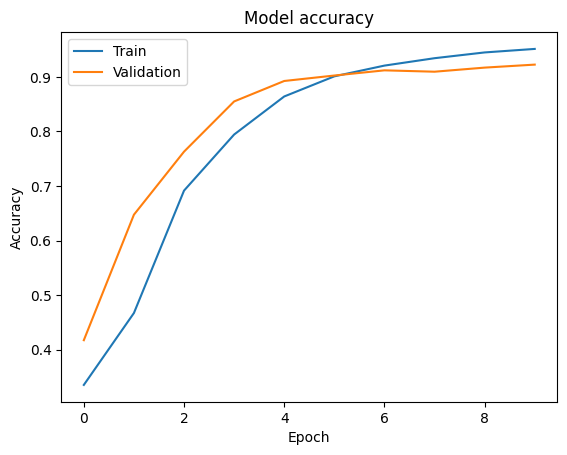

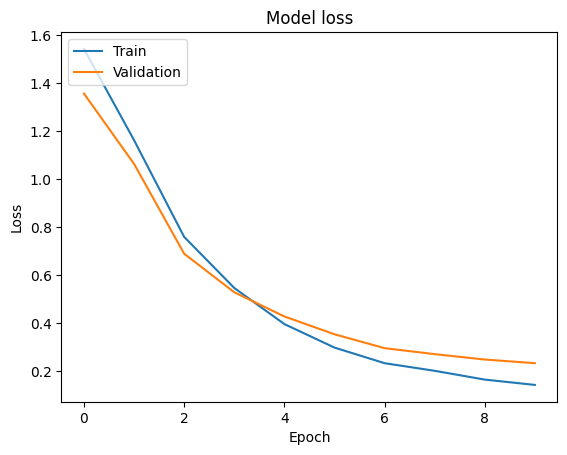

In [62]:
plot_training_history(history)

In [55]:
# Accuracy Time
from sklearn.metrics import classification_report, accuracy_score

In [57]:
y_pred = model.predict(X_test_padded)

63/63 [==============================] - 2s 15ms/step


In [59]:
print(classification_report(test_data["emotion"], y_pred.argmax(axis=1)))

              precision    recall  f1-score   support

           0       0.94      0.94      0.94       695
           1       0.97      0.96      0.96       581
           2       0.93      0.94      0.93       275
           3       0.84      0.90      0.87       224
           4       0.84      0.79      0.81       159
           5       0.75      0.70      0.72        66

    accuracy                           0.92      2000
   macro avg       0.88      0.87      0.87      2000
weighted avg       0.92      0.92      0.92      2000



In [63]:
def save_model(model, model_name):
    model.save(f'models/{model_name}.h5')
    print(f'Model saved as {model_name}.h5')

In [64]:
save_model(model, 'NN_model')

Model saved as NN_model.h5


c:\Users\Abdulmunim\Desktop\emotika\.venv\Lib\site-packages\keras\src\engine\training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [65]:
# save the tokenization and preprocessing

import pickle


def save_tokenizer(tokenizer, tokenizer_name):
    with open(f'tokenizers/{tokenizer_name}.pickle', 'wb') as handle:
        pickle.dump(tokenizer, handle, protocol=pickle.HIGHEST_PROTOCOL)
    print(f'Tokenizer saved as {tokenizer_name}.pickle')

In [67]:
save_tokenizer(tokenizer, 'NN_tokenizer')

Tokenizer saved as NN_tokenizer.pickle
